### 0. Setup

#### 0.1. Import

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__ # verify torch version

'2.5.1+cpu'

#### 0.2. Verify GPU Access

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device type: {device}") # Verify GPU Access

Device type: cpu


### 1. Data

#### 1.1. Create a Dataset

In [3]:
w = 0.7
b = 0.3

start, end, step = 0, 1, 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = w*X + b

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

#### 1.2. Split data into training & test sets

In [4]:
train_split = int(0.8 * len(X)) # train:test = 80:20

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

#### 1.3. Visualize data

In [5]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

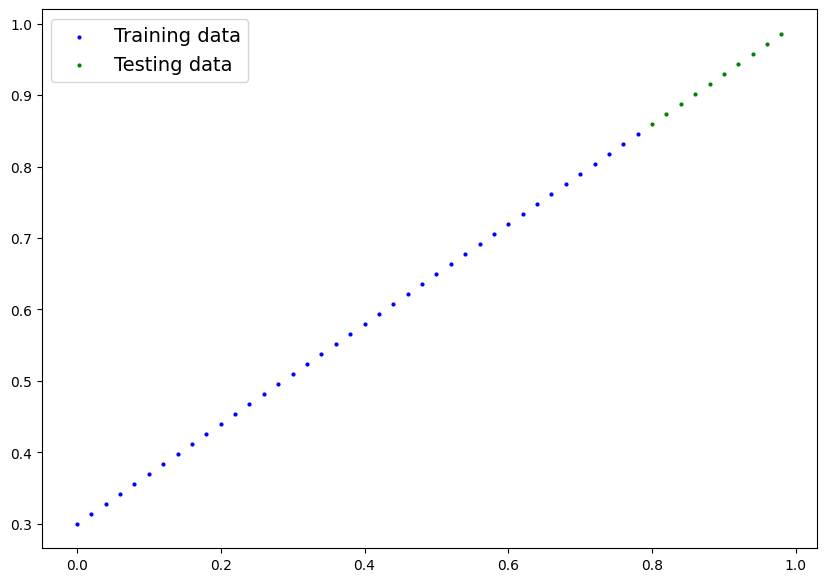

In [6]:
plot_predictions()

### 2. Build a Model

#### 2.1. Model Class Creation
**LinearRegressionModelV1**
- **Type**: Custom implementation of linear regression.
- **Components**:
  - `weights`: A trainable parameter (`nn.Parameter`) initialized with random values.
  - `bias`: A trainable parameter (`nn.Parameter`) initialized with random values.
- **Forward Method**:
  - Implements the formula: $y = \text{weights} \cdot x + \text{bias}$.
  - Requires manual definition of the linear relationship.

---

**LinearRegressionModelV2**
- **Type**: Built-in implementation using `nn.Linear`.
- **Components**:
  - `linear_layer`: A predefined linear transformation layer (`nn.Linear`) with:
    - **Input Features (`in_features`)**: 1
    - **Output Features (`out_features`)**: 1
- **Forward Method**:
  - Passes the input tensor ($x$) through the `linear_layer` for automatic computation of the linear regression.



In [7]:
class LinearRegressionModelV1(nn.Module): # subclass of nn.Module
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1,
                                                dtype=torch.float),
                                   requires_grad=True) # update this value with gradient descent

        self.bias = nn.Parameter(torch.randn(1,
                                            dtype=torch.float),
                                requires_grad=True) # update this value with gradient descent

    def forward(self, x: torch.Tensor) -> torch.Tensor: # "x": input data
        return self.weights * x + self.bias # linear regression formula

In [8]:
class LinearRegressionModelV2(nn.Module): # subclass of nn.Module
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
                                          
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

#### 2.2. Checking contents of the model

In [9]:
torch.manual_seed(42)

model_1 = LinearRegressionModelV1()
model_2 = LinearRegressionModelV2()

# 1. check its parameters
print(f"V1 Parameter: {list(model_1.parameters())}")
print(f"V2 Parameter: {list(model_2.parameters())}")

# 2. check the model's state
print(f"V1 State: {model_1.state_dict()}")
print(f"V2 State: {model_2.state_dict()}")

# # OPTIONAL: run models on GPU
# next(model_1.parameters()).device
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model_1.to(device) # move to gpu
# next(model_1.parameters()).device

V1 Parameter: [Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]
V2 Parameter: [Parameter containing:
tensor([[-0.2191]], requires_grad=True), Parameter containing:
tensor([0.2018], requires_grad=True)]
V1 State: OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])
V2 State: OrderedDict([('linear_layer.weight', tensor([[-0.2191]])), ('linear_layer.bias', tensor([0.2018]))])


#### 2.3. Make predictions

In [10]:
with torch.inference_mode(): 
    y_preds1 = model_1(X_test)
    y_preds2 = model_2(X_test)
y_preds1, y_preds2

(tensor([[0.3982],
         [0.4049],
         [0.4116],
         [0.4184],
         [0.4251],
         [0.4318],
         [0.4386],
         [0.4453],
         [0.4520],
         [0.4588]]),
 tensor([[ 0.0265],
         [ 0.0221],
         [ 0.0177],
         [ 0.0134],
         [ 0.0090],
         [ 0.0046],
         [ 0.0002],
         [-0.0042],
         [-0.0085],
         [-0.0129]]))

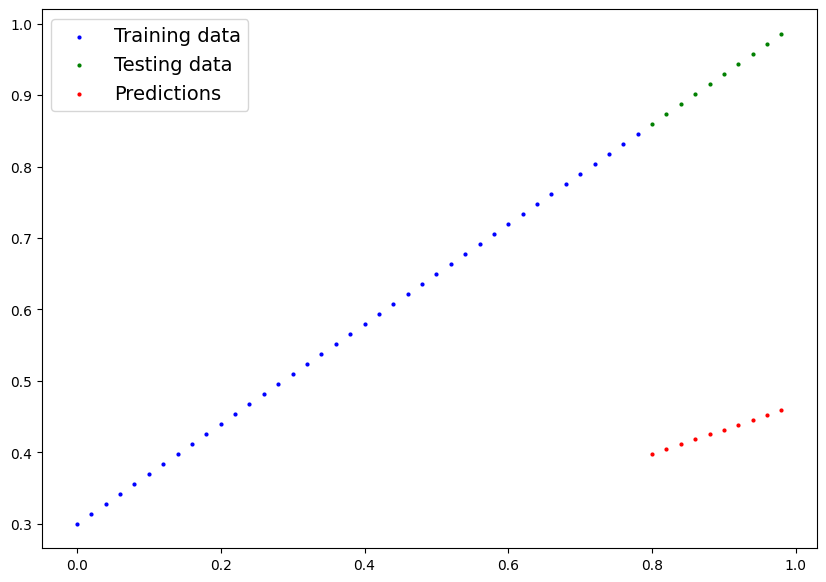

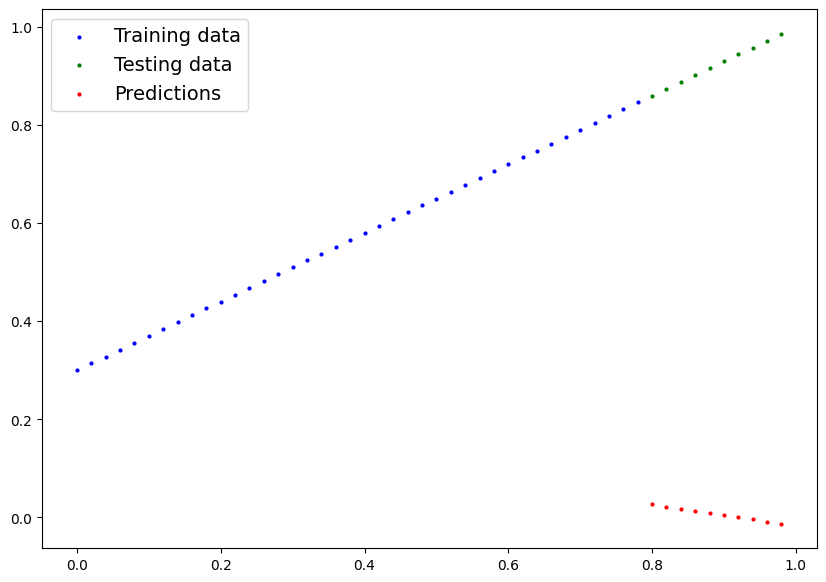

In [11]:
plot_predictions(predictions=y_preds1) # prediction for v1 lin reg
plot_predictions(predictions=y_preds2) # prediction for v2 lin reg

### 3. Training

#### 3.1. Initialize Loss Function & Optimizer

- **Loss Function**: Used `nn.L1Loss` (Mean Absolute Error) to measure the absolute differences between predictions and actual values.
- **Optimizer**: Used `torch.optim.SGD` (Stochastic Gradient Descent) with:
  - **Learning Rate**: `0.01`
  - **Parameters**: Model parameters for both `model_1` and `model_2`.


In [12]:
# Create the loss function
loss_fn = nn.L1Loss()

# Create the optimizer
optimizer1 = torch.optim.SGD(params=model_1.parameters(), # model param
                            lr=0.01) # learning rate

optimizer2 = torch.optim.SGD(params=model_2.parameters(), # model param
                            lr=0.01) # learning rate

#### 3.2. Optimization Loop

In [13]:
torch.manual_seed(42)

epochs = 200  # Number of entire data passes
modelToOptimizer = {model_1: optimizer1, model_2: optimizer2}
results = {
    model_1: {"train_loss": [], "test_loss": [], "epochs": [], "test_preds": None},
    model_2: {"train_loss": [], "test_loss": [], "epochs": [], "test_preds": None},
}

# Training and Testing Loop
for model_key, optimizer in zip(modelToOptimizer.keys(), modelToOptimizer.values()):
    print(f"Training {model_key}")
    
    for epoch in range(epochs):
        ### Training
        # Toggle train mode on
        model_key.train()
    
        # 1. Forward pass using the forward()
        y_pred = model_key(X_train)
    
        # 2. Calculate the loss
        loss = loss_fn(y_pred, y_train)
    
        # 3. Zero grad of the optimizer (reset! otherwise accumulates)
        optimizer.zero_grad()
    
        # 4. Loss backwards (backpropagation)
        loss.backward()
    
        # 5. Progress the optimizer (gradient descent)
        optimizer.step()
    
        ### Testing
        # Toggle evaluation mode on
        model_key.eval()
        
        with torch.inference_mode():
            # 1. Forward pass on test data
            test_pred = model_key(X_test)
    
            # 2. Calculate loss on test data
            test_loss = loss_fn(test_pred, y_test.type(torch.float))
    
            # Debug and store results
            if epoch % 10 == 0:
                results[model_key]["epochs"].append(epoch)
                results[model_key]["train_loss"].append(loss.detach().numpy())
                results[model_key]["test_loss"].append(test_loss.detach().numpy())
                print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")
            
            # Store test predictions only in the final epoch
            if epoch == epochs - 1:
                results[model_key]["test_preds"] = test_pred.detach().numpy()  # Replace None with final test predictions

# Access final predictions
y_preds1 = results[model_1]["test_preds"]
y_preds2 = results[model_2]["test_preds"]


Training LinearRegressionModelV1()
Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819
Epoch: 100 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05646304413676262
Epoch: 110 | MAE Train Loss: 0.

#### 3.3. Visualization of Epochs vs Loss

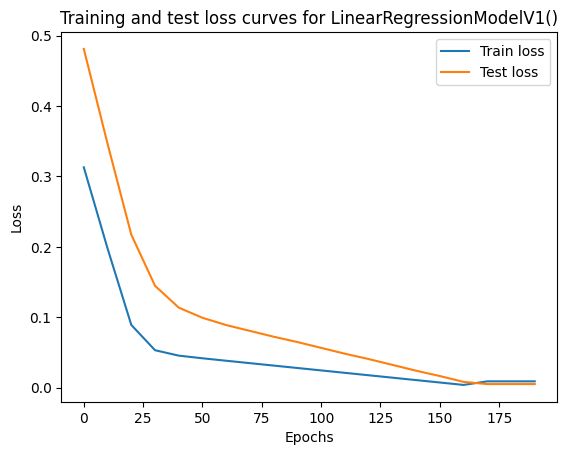

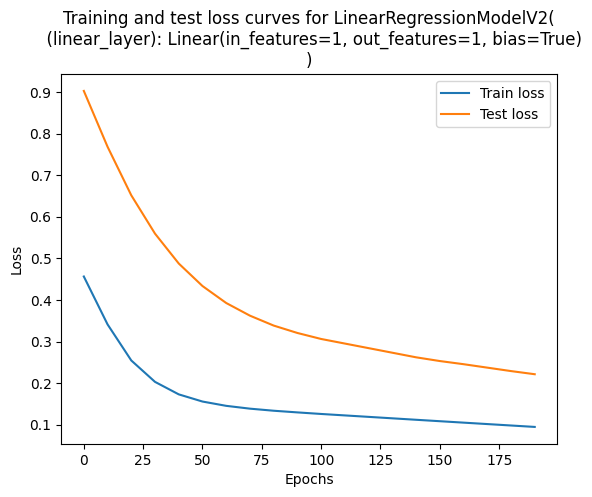

In [14]:
# Plot the loss curves

for model_key in results.keys():
    plt.figure()  # Create a new figure for each model
    plt.plot(results[model_key]["epochs"], results[model_key]["train_loss"], label="Train loss")
    plt.plot(results[model_key]["epochs"], results[model_key]["test_loss"], label="Test loss")
    plt.title(f"Training and test loss curves for {model_key}")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

### 4. Saving / Loading Model

#### 4.1. Saving a model's state (`state_dict()`)

In [15]:
from pathlib import Path

# Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
models = {"linear_regression_v1": model_1, "linear_regression_v2": model_2}

for model_name, model_obj in models.items():
    # Define the save path for each model
    MODEL_SAVE_PATH = MODEL_PATH / f"{model_name}.pth"
    print(f"Saving {model_name} to: {MODEL_SAVE_PATH}")
    # Save the state_dict
    torch.save(obj=model_obj.state_dict(), f=MODEL_SAVE_PATH)

Saving linear_regression_v1 to: models\linear_regression_v1.pth
Saving linear_regression_v2 to: models\linear_regression_v2.pth


In [16]:
!dir models /B

linear_regression_v1.pth
linear_regression_v2.pth


#### 4.2. Load a model
- Assume we want to load version 1

In [17]:
loaded_model_1 = LinearRegressionModelV1()
loaded_model_1.load_state_dict(torch.load(f=MODEL_PATH/"linear_regression_v1.pth", weights_only=True))

<All keys matched successfully>

In [18]:
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model1_preds = loaded_model_1(X_test)
    
y_preds1 == loaded_model1_preds # same results!

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])